In [1]:
import numpy as np
from PIL import Image
import PIL

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.applications import resnet50

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import pathlib

/Users/john_calimoso/Documents/John Folder/AI Model to Deploy/AI Model/Dataset/Guinea Pig
/Users/john_calimoso/Documents/John Folder/AI Model to Deploy/AI Model/Dataset/Guinea Pig/Rex Guinea Pig/Rex_Guinea_Pig_original_Rex_Guinea_Pig9.jpg_1f85adda-ce40-4266-8a7b-4f1d65734c0f.jpg


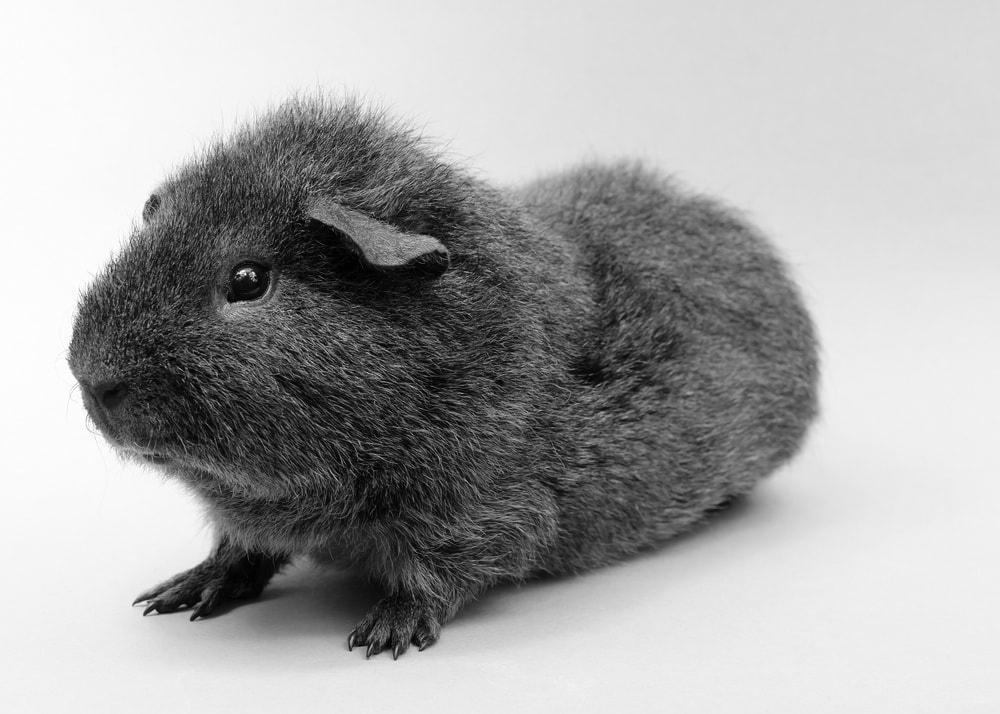

In [2]:
data_dir = pathlib.Path("../../Dataset/Guinea Pig")     # modified the path due to error in file naming
#show path location
print(data_dir)
#show sample image
TGP = list(data_dir.glob('Rex Guinea Pig/*'))
print(TGP[500])
PIL.Image.open(str(TGP[500]))

In [3]:
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


In [4]:
class_names = train_ds.class_names

# Convert tensorflow dataset to numpy array

In [5]:
# Extract x_train and y_train from the train_ds
x_train = []
y_train = []

for images, labels in train_ds:
    x_train.append(images.numpy())  # Convert TensorFlow tensor to NumPy array
    y_train.append(labels.numpy())

In [6]:
# Convert x_train and y_train to NumPy arrays
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [7]:

# Verify the shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (8000, 224, 224, 3)
y_train shape: (8000,)


In [8]:
# Extract x_test and y_test from the train_ds
x_test = []
y_test = []

for images, labels in val_ds:
    x_test.append(images.numpy())  # Convert TensorFlow tensor to NumPy array
    y_test.append(labels.numpy())

In [9]:
# Convert x_train and y_train to NumPy arrays
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [10]:

# Verify the shapes
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (2000, 224, 224, 3)
y_test shape: (2000,)


# pre process the data

In [11]:
def lowSampleDataset(X, Y):
    perm = np.random.permutation(X.shape[0])
    X = X[perm[0 : (int)(X.shape[0] * (20/100))]]
    Y = Y[perm[0 : (int)(Y.shape[0] * (20/100))]]
    return X, Y
     

In [12]:
print('\tOriginal training set shape: ', x_train.shape)
print('\tOriginal testing set shape: ', x_test.shape)

print("Reducing the dataset size ...")
Xtrain, Ytrain = lowSampleDataset(x_train, y_train)
Xtest, Ytest = lowSampleDataset(x_test, y_test)

# print("Changing the dataset resolution ...")
# X = []
# for i in range(0, Xtrain.shape[0]):
#     X.append(np.array(Image.fromarray(Xtrain[i]).resize(size=(256,256))))
# Xtrain = np.array(X)

# X = []
# for i in range(0, Xtest.shape[0]):
#     X.append(np.array(Image.fromarray(Xtest[i]).resize(size=(256,256))))
# Xtest = np.array(X)

print('\tTraining set shape: ', Xtrain.shape)
print('\tTesting set shape: ', Xtest.shape)

	Original training set shape:  (8000, 224, 224, 3)
	Original testing set shape:  (2000, 224, 224, 3)
Reducing the dataset size ...
	Training set shape:  (1600, 224, 224, 3)
	Testing set shape:  (400, 224, 224, 3)


In [13]:

print("Loading the ResNet50-ImageNet model ...")
model = resnet50.ResNet50(include_top=True, weights='imagenet', pooling='avg', input_shape=(img_height, img_width, 3), classes=1000)
model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)

print("Feature extraction ...")
prediction = np.array(model.predict(Xtrain))
Xtrain = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

prediction = np.array(model.predict(Xtest))
Xtest = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

print('\tFeatures training shape: ', Xtrain.shape)
print('\tFeatures testing shape: ', Xtest.shape)

Loading the ResNet50-ImageNet model ...
Feature extraction ...
13/13 [==============================] - 3s 190ms/step
	Features training shape:  (1600, 2048)
	Features testing shape:  (400, 2048)


In [14]:
print("Classification with Linear SVM ...")
svm = SVC(kernel='rbf', probability=True)
svm.fit(Xtrain, np.ravel(Ytrain, order='C'))
result = svm.predict(Xtest)

acc = accuracy_score(result, np.ravel(Ytest, order='C'))
print("\tAccuracy Linear SVM: %0.4f" % acc)

Classification with Linear SVM ...
	Accuracy Linear SVM: 0.8575


In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
cm = confusion_matrix(Ytest, result)
print(cm)

[[24  2  0  1  0  0  0  3  0  0]
 [ 4 31  0  0  0  0  0  0  0  5]
 [ 2  0 35  1  0  1  0  1  0  1]
 [ 6  0  0 39  0  2  0  0  0  0]
 [ 0  1  1  0 28  0  0  5  0  0]
 [ 1  1  1  0  0 44  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  0]
 [ 0  2  3  0  2  0  0 34  0  0]
 [ 1  0  0  1  0  0  0  1 34  0]
 [ 1  2  3  0  0  0  0  1  1 41]]


In [17]:
from sklearn.metrics import classification_report

print(classification_report(Ytest, result))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        30
           1       0.79      0.78      0.78        40
           2       0.81      0.85      0.83        41
           3       0.93      0.83      0.88        47
           4       0.93      0.80      0.86        35
           5       0.94      0.94      0.94        47
           6       1.00      1.00      1.00        33
           7       0.76      0.83      0.79        41
           8       0.97      0.92      0.94        37
           9       0.87      0.84      0.85        49

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



# practical prediction

In [18]:
import cv2

In [19]:

img = PIL.Image.open("/Users/john_calimoso/Documents/John Folder/Thesis Project/ResnetTransferLearning/Sample Picture For Testing/bis_black_himalayan_saywell_med.jpeg")
img = img.convert("RGB")
img= np.asarray(img)
image_resized= cv2.resize(img, (224,224))

In [20]:
features = model.predict(np.expand_dims(image_resized, axis=0))

1/1 [==============================] - 1s 673ms/step


In [21]:
reshaped_features = features.reshape(features.shape[0],-1)

In [22]:
predicted_class = svm.predict(reshaped_features)
predicted_class

array([2], dtype=int32)

In [23]:
print("Predicted Class: ", class_names[predicted_class[0]])


Predicted Class:  Himalayan Guinea Pig


# saving the model

In [29]:
import joblib
import pickle

In [30]:
data_to_save = {
    'class_name': class_names,
    'svm_model': svm
}
with open("dataSaved.pkl", 'wb') as file:
    pickle.dump(data_to_save, file)

model.save('resnet_EXTRACTOR.h5')

/Users/john_calimoso/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
